# PINN #2 (Simpler)

## Import Relevant Packages

In [1]:
import pandas as pd
from sciann import Variable, Functional, SciModel
import numpy as np

---------------------- SCIANN 0.6.1.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 


## Load Data from Folder

In [2]:
import glob

df = pd.concat(map(pd.read_csv, glob.glob('data/*.csv')))
df

,T_Bottom,Time,X,Y,Temp(degC)
0,100,0.0,0.5,1.00,20.012003
1,100,0.0,1.0,1.00,19.997972
2,100,0.0,1.5,1.00,19.995835
3,100,0.0,2.0,1.00,19.992627
4,100,0.0,2.5,1.00,19.993528
...,...,...,...,...,...
3095,100,15.0,50.0,1.92,99.616917
3096,100,15.0,50.0,1.94,99.613966
3097,100,15.0,50.0,1.96,99.611026
3098,100,15.0,50.0,1.98,99.608099


In [3]:
# Shuffle the data so it's easy for the model to learn
df = df.sample(frac=1).reset_index(drop=True)
df

,T_Bottom,Time,X,Y,Temp(degC)
0,100,0.0,46.0,2.00,19.999941
1,100,5.0,45.0,0.00,100.000000
2,100,4.0,0.0,1.46,99.689989
3,100,9.0,43.0,2.00,99.810113
4,100,12.0,6.5,2.00,99.805667
...,...,...,...,...,...
15495,100,3.0,0.0,1.44,99.692986
15496,100,4.0,22.5,2.00,99.838396
15497,100,15.0,50.0,0.36,99.901496
15498,100,15.0,50.0,1.02,99.767036


In [4]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
df[df.isna().any(axis=1)]

,T_Bottom,Time,X,Y,Temp(degC)


## Convert columns into NumPy arrays and scale them

In [5]:
t_np = df['Time']
x_np = df['X']
y_np = df['Y']
temp_np = df['Temp(degC)']

t_np = (t_np.to_numpy().reshape(-1,1))
x_np = (x_np.to_numpy().reshape(-1,1))
y_np = (y_np.to_numpy().reshape(-1,1))
temp_np = (temp_np.to_numpy().reshape(-1,1))

## Define Inputs and Targets for PINN

In [6]:
# Define the necessary inputs and parameter using Variable and Parameter
t = Variable('t')
x = Variable('x')
y = Variable('y')

# Define Neural Network Approximations
T = Functional('T', [t,x,y], 8*[20], 'tanh')

## Define Scaling Factors

In [22]:
from sciann import Parameter
lambda2 = Parameter(val=0.0, min_max = [0,1e-6], inputs=[t,x,y], name="lambda2")
lambda3 = Parameter(val=0.0, min_max = [0,1e-6], inputs=[t,x,y], name="lambda3")
lambda4 = Parameter(val=0.0, min_max = [0,1e-6], inputs=[t,x,y], name="lambda4")
lambda5 = Parameter(val=0.0, min_max = [0,1e-6], inputs=[t,x,y], name="lambda5")
lambda6 = Parameter(val=0.0, min_max = [0,1e-6], inputs=[t,x,y], name="lambda6")

## Define Constants and PDE

In [8]:
# Constants

H = 352.1 #1
A = 2e5 #2
E_a = 51100 #3 
n = 1.927 #4
p = 980 #5
c_p = 1440 #6
k = 1.8 #7
R = 8.314 #8
T_o = 20 #9
a_o = 0 #10
h = 1.8 #11
T_bottom = 100 #12

# PDE
from sciann.utils.math import diff, sign, exp, pow
T_xx = diff(T, x, order=2)
T_yy = diff(T, y, order=2)
T_t = diff(T,t)

L1 = (k/(p*c_p))*T_xx + (k/(p*c_p))*T_yy - T_t

## Define Initial and Boundary Conditions

In [9]:
# t: [0,15]
# x: [0,50]
# y: [0,2]
# Q: [500,700]

tmin = 0
Xmin = 0
Xmax = 50
Ymin = 0
Ymax = 2

# Boundary Conditions
L2 = (k*diff(T, x))*(1-sign(x - Xmin)) + (h*T)*(1-sign(x - Xmin)) - (h*T_o)*(1-sign(x - Xmin))

L3 = (k*diff(T, x))*(1+sign(x - Xmax)) + (h*T)*(1+sign(x - Xmax)) - (h*T_o)*(1+sign(x - Xmax))

L4 = (k*diff(T, y))*(1-sign(y - Ymin)) + (h*T)*(1-sign(y - Ymin)) - (h*T_o)*(1-sign(y - Ymin))

L5 = (diff(T,y) - T_bottom)*(1+sign(y - Ymin))

# Initial Conditions
L6 = (1-sign(t - tmin))*(T-T_o)

L_TOTAL = L1 + lambda2*L2 + lambda3*L3 + lambda4*L4 + lambda5*L5 + lambda6*L6
L_DATA = T

## Build and Train Model

In [10]:
m = SciModel([t,x,y], [L_TOTAL, L_DATA])

In [11]:
h = m.train(
    [t_np, x_np, y_np], 
    ['zeros', temp_np], 
    epochs=15000,
    batch_size=128,
    verbose = 0,
    shuffle=False)


Total samples: 15500 
Batch size: 128 
Total batches: 122 


Epoch 02927: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 09804: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11708: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 13208: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 14708: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


## Get Model Predictions

In [12]:
# Actual Value (99.734648)
T.eval([np.array(9.5), np.array(2.5), np.array(2.0)])

array(99.74154, dtype=float32)

In [13]:
T_pred = T.eval([t_np, x_np, y_np])

In [14]:
from sklearn.metrics import mean_squared_error as mse
import math
print('TEMPERATURE RMSE: ')
print(round(math.sqrt(mse(temp_np, T_pred)), 3))

TEMPERATURE RMSE: 
0.028


Text(0, 0.5, 'loss')

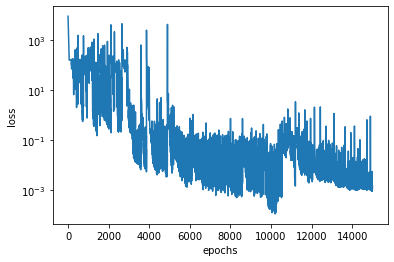

In [15]:
import matplotlib.pyplot as plt
plt.semilogy(h.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

In [16]:
lambda2.value

array([-9.928408e-07], dtype=float32)

In [17]:
lambda3.value

array([-9.462524e-07], dtype=float32)

In [18]:
lambda4.value

array([-9.841174e-07], dtype=float32)

In [19]:
lambda5.value

array([-9.879186e-07], dtype=float32)

In [20]:
lambda6.value

array([9.563047e-07], dtype=float32)